<a href="https://colab.research.google.com/github/pkhaan/AutoCuratedMovieLists/blob/master/social_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

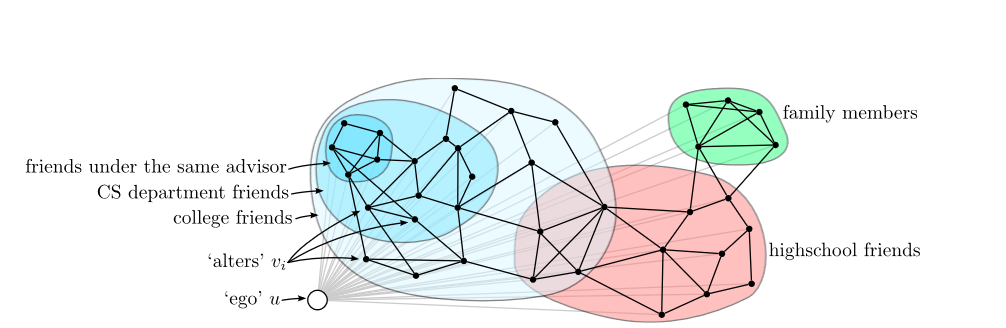

*An ego-network with labeled circles. This network shows typical behavior that we observe in our data: Approximately 25% of our ground-truth circles (from Facebook) are contained completely within another circle, 50% overlap with another circle, and 25% of the circles have no members in common with any other circle. The goal is to discover these circles given only the network between the ego’s friends. We aim to discover circle memberships and to find common
properties around which circles form. (See the following [paper](http://i.stanford.edu/~julian/pdfs/nips2012.pdf)).*

# Scraping the data

[](data:text/plain;charset=utf-8;base64,QGluUHJvY2VzcyB7bWNhdWxleTIwMTIxMjpsZWFybmluZywgYXV0aG9yeT1KYXZhbiBhbmQgTGVza292ZWMsIGJvb2t0aWxlPUFkdmFuY2VzIGluIE5ldXJhbCBJbmZvcm1hdGlvbiBQcm9jZXNzcyBTY2llbnRpc3MgKE5JUFMpLCB5ZWFyPTIwMTIgfQ==)


In [1]:
import requests
import tarfile
import io
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
import pandas as pd

import statistics
%matplotlib inline


In [37]:
# URL of the tar.gz file
!wget "https://snap.stanford.edu/data/twitter_combined.txt.gz"

--2024-03-24 12:42:39--  https://snap.stanford.edu/data/twitter_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10621918 (10M) [application/x-gzip]
Saving to: ‘twitter_combined.txt.gz’

twitter_combined.tx 100%[===================>]  10.13M  7.53MB/s    in 1.3s    

2024-03-24 12:42:41 (7.53 MB/s) - ‘twitter_combined.txt.gz’ saved [10621918/10621918]



In [39]:
url = "https://snap.stanford.edu/data/twitter.tar.gz"

# Downloading the file
response = requests.get(url)
if response.status_code == 200:
    with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz") as tar:
        tar.extractall()
    print("Data downloaded and extracted successfully.")
else:
    print("Failed to download the data.")

Data downloaded and extracted successfully.


## Helper Functions

In [3]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)

    # (a)
    nx.draw(G,pos=nx.spring_layout(G),node_color='maroon',
        node_size=20,
        edge_color="gray",
        width=0.5)
    plt.show()
    # (b)
    if directed:
        in_degree_sequence = [item[-2] for item in local_summaries(G)]
        in_degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()

        out_degree_sequence = [item[-1] for item in local_summaries(G)]
        out_degree_counts = Counter(out_degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()
    else:
        degree_sequence = [item[-1] for item in local_summaries(G)]
        degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show()
    # (c)
    betweenness_centrality = [item[0] for item in local_summaries(G)]
    fig1, ax1 = plt.subplots()
    ax1.hist(betweenness_centrality)
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()
    # (d)
    eigenvector_centrality = [item[1] for item in local_summaries(G)]
    fig2, ax2 = plt.subplots()
    ax2.hist(eigenvector_centrality)
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()
    # Print Global Summaries
    global_summaries(G)

In [4]:
def local_summaries(G, directed=False):
    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        out_degrees = [G.in_degree(n) for n in G.nodes]
        return zip(betweenness_centrality.values(), eigenvector_centrality.values(), closeness_centrality.values(), in_degrees, out_degrees)
    else:
        degrees = [G.degree(n) for n in G.nodes]
        return zip(betweenness_centrality.values(), eigenvector_centrality.values(), closeness_centrality.values(), degrees)

In [32]:
def global_summaries(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_nodes()
    number_of_edges = G.number_of_edges()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("##### Global Summaries #####")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

In [6]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content} # Convert nodes to int and add to dict.

In [7]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

## Apply different centrality metrics

In [41]:
G = nx.read_edgelist('twitter/100318079.edges', nodetype=int)

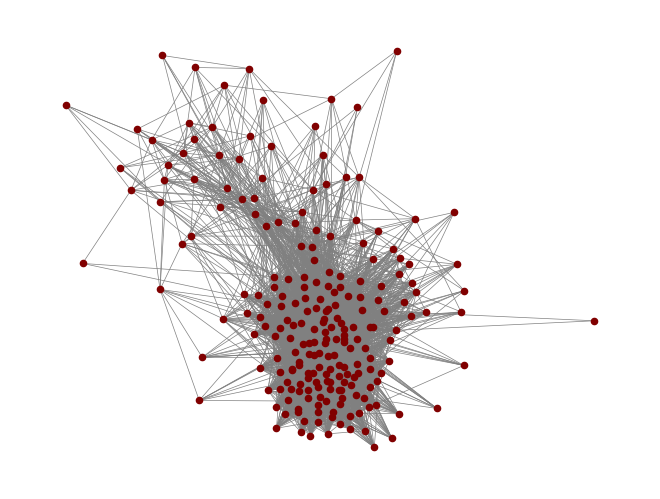

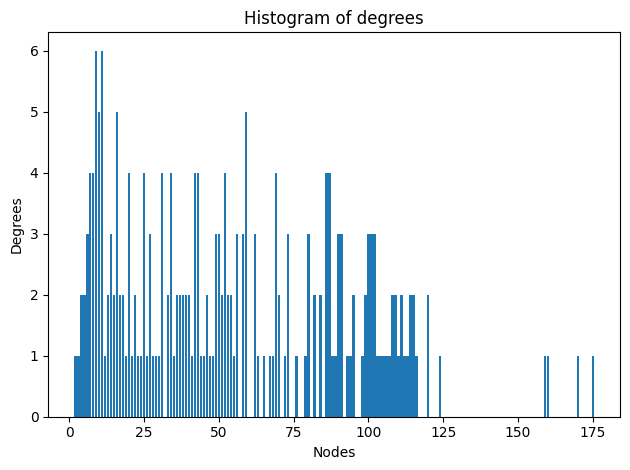

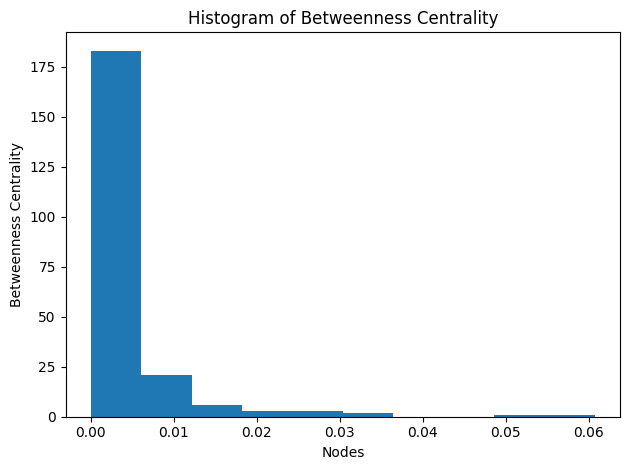

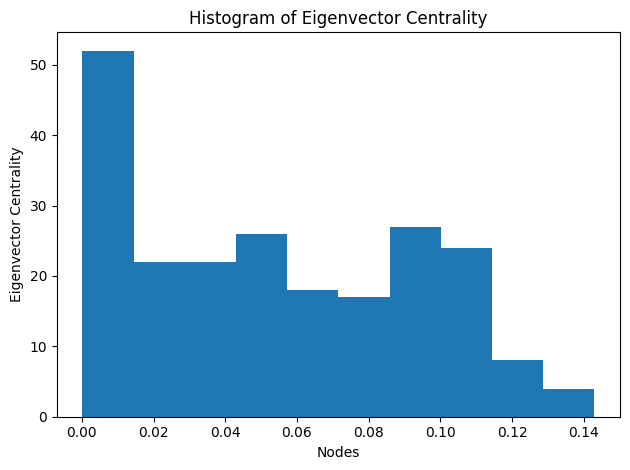

##### Global Summaries #####
Diameter :  4
Number of Nodes :  220
Number of Edges :  5971
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  220


In [42]:
explore_and_summarize_network(edgelist = G.edges(), vertices=G.nodes(), subgraph=None)